In [1]:
import torch
import math
from all_code import GPTModel, create_dataloader, generate_text_simple
from datasets import load_from_disk
from bpe import HindiTokenizer
from tqdm import tqdm

GPT_CONFIG_124M = {
    "vocab_size": 32000,   # Vocabulary size
    "context_length": 128, # Shortened context length (orig: 1024)
    "emb_dim": 256,        # Embedding dimension
    "n_heads": 4,         # Number of attention heads
    "n_layers": 4,        # Number of layers
    "drop_rate": 0.2,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
model.eval();

In [2]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)
    return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "You are a help assistant"
tokenizer = HindiTokenizer()
token_ids = generate_text_simple(
model=model,
idx=text_to_token_ids(start_context, tokenizer),
max_new_tokens=10,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 You are a help assistant सिक् हॉलैंडBruceendrickवर्जिनईछविoricallyified navigationयासरत


In [3]:
dataset = load_from_disk("/home/angkul/my_data/coding/agi/hindi_GPT/combined_dataset").shuffle(seed=42)

In [4]:
split = dataset.train_test_split(test_size=0.2, seed=123)
train_data = split['train']['text']
val_data = split['test']['text']

In [5]:
torch.manual_seed(32)

train_loader = create_dataloader(
    train_data,
    batch_size=16,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length']//2,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=16,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length']//2,
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [6]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 128]) torch.Size([16, 128])
torch.Size([16, 12

In [7]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss
    
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss/num_batches

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)


torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: tensor(10.5232, device='cuda:0')
Validation loss: tensor(10.5222, device='cuda:0')


In [9]:
!nvidia-smi

Sun May 18 07:13:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2050        Off |   00000000:01:00.0 Off |                  N/A |
| N/A   76C    P0             28W /   30W |     977MiB /   4096MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) 
    model.train()

In [11]:
def train_model(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer, warmup_steps, initial_lr=3e-05, min_lr=1e-6):
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1

    peak_lr = optimizer.param_groups[0]["lr"]
    total_training_steps = len(train_loader) * num_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in tqdm(range(num_epochs)):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            global_step += 1

            if global_step < warmup_steps:
                lr = initial_lr + global_step*lr_increment
            else:
                # cosine annealing
                progress = ((global_step - warmup_steps)/(total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr-min_lr)*0.5*(1 + math.cos(math.pi * progress))

            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
            track_lrs.append(lr)

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()

            if global_step >= warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            tokens_seen += input_batch.numel()

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

num_epochs = 50
total_steps = len(train_loader) * num_epochs
warmup_steps = int(0.2 * total_steps)

train_losses, val_losses, tokens_seen = train_model(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="You are a helpful assistant", tokenizer=tokenizer, warmup_steps=warmup_steps,
    initial_lr=3e-05, min_lr=1e-6
)

In [13]:
def to_cpu_numpy(x):
    if torch.is_tensor(x):
        return x.detach().cpu().numpy()
    return x

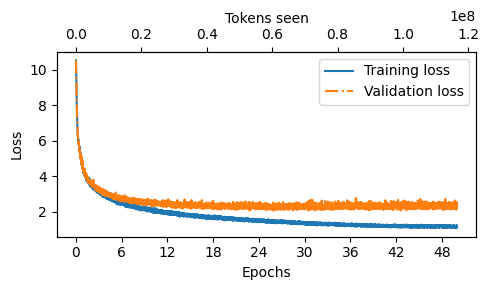

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(
    epochs_tensor.cpu(),
    tokens_seen,
    [loss.item() for loss in train_losses],
    [loss.item() for loss in val_losses]
)

In [15]:
model.to("cuda")
model.eval()

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("पिचके लबों और चौड़े चौड़े किलों के ऊपर दो बड़ी बड़ी गहिरी स्याह आँखें अजीब सी लगती थीं", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 पिचके लबों और चौड़े चौड़े किलों के ऊपर दो बड़ी बड़ी गहिरी स्याह आँखें अजीब सी लगती थीं और बटगमनी जवाब दिया-' नीचे सताइस-अठाइस, ऊपर तीस। जैसा माल,


In [4]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)  

            idx_next = torch.multinomial(probs, num_samples=1)

        
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [17]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Life is hard.", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Life is hard. But ohia, go," her owner said. There was


In [18]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

total_params_gpt2 = (
total_params - sum(p.numel()
for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
f"considering weight tying: {total_params_gpt2:,}"
)

Total number of parameters: 19,573,248
Number of trainable parameters considering weight tying: 11,381,248


In [19]:
torch.save(model.state_dict(), "gpt20k_model.pt")
torch.save(model, "gpt20k_full_model.pt")

In [10]:
model.load_state_dict(torch.load("gpt20k_model.pt"))

# Save in Hugging Face format
model.save_pretrained("./")

/tmp/ipykernel_2808/328053248.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gpt20k_model.pt"))


In [14]:
model1 = torch.load("gpt20k_full_model.pt")

torch.manual_seed(123)

token_ids = generate(
    model=model1,
    idx=text_to_token_ids("पिचके लबों और चौड़े चौड़े किलों के ऊपर दो बड़ी बड़ी गहिरी स्याह आँखें अजीब सी लगती थीं", tokenizer),
    max_new_tokens=256,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

/tmp/ipykernel_2808/2191131054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model1 = torch.load("gpt20k_full_model.pt")


Output text:
 पिचके लबों और चौड़े चौड़े किलों के ऊपर दो बड़ी बड़ी गहिरी स्याह आँखें अजीब सी लगती थीं और फिर हुआ के सीने में झुकते हुए रहे।' लेकिन हिरामन ने दमना दिया-आइन हुए भी मैंने अकुंठित भाव से अपना आशय प्रकट कर दिया-ए-आ-आ मोती झरय काें स् ⁇  तुम भी न पाई हो exhausted उस से दूधतव हैं, जोतव की छोटी लाठी से मुनीम के बारे मेरे क़दमवज् हो गए हैं और रेल की पटरी की कर दिए जा-आना तकामन ने फिर सब मिलकर का एकख।ों तक, जैसे हर जानेलुक हैं।'ve come and find you ⁇  Good। Peter ancest यह।' जना तक ⁇ , जनान् नहीं, यह।' गाड़ी से नहीं जाना चाहती के मुलुक उस के क़ फिर जना उठा का।' गाड़ी से का का हुए दिल बle। और अब जना उठा नेगी-जा-आ के लिए।' माँ।' गाड़ी जी,'।'' जना तक, नहींisting के वरते हुए दिल।' माँ।' गाड़ी से हिरामन ने द का।' गाड़ीवान, जना तक।'' जना तक ⁇ '  ⁇ Harry realized that he was right one 


In [20]:
import json

config = {
    "vocab_size": 8000,
    "context_length": 128,
    "emb_dim": 256,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": True
}
with open("config.json", "w") as f:
    json.dump(config, f)


In [ ]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)